# Graphs for params sensitivity in paper

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [4]:
import sys
sys.path.append('../')

In [3]:
import neptune

In [5]:
def convert_to_dataset_name(target_app: str, middleware: bool, manually_selected: bool) -> str:
    match target_app, middleware, manually_selected:
        case "sock-shop", _, True:
            return "SS-small"
        case "sock-shop", False, False:
            return "SS-medium"
        case "sock-shop", True, False:
            return "SS-large"
        case "train-ticket", _, True:
            return "TT-small"
        case "train-ticket", False, False:
            return "TT-medium"
        case "train-ticket", True, False:
            return "TT-large"
        case _:
            raise ValueError(f"Unknown combination: {target_app}, {middleware}, {manually_selected}")

In [42]:
## download from neptune
TSDR_START_ID, TSDR_END_ID = 859, 899
TSDR_SKIP_IDS = []
TSDR_RUN_IDS = [f"TSDR-{i}" for i in range(TSDR_START_ID, TSDR_END_ID + 1) if i not in TSDR_SKIP_IDS]

In [40]:
import neptune.exceptions

def fetch_metadata_of_tsdr(run_id: str) -> dict[str, str|float]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return {}
        try:
            dataset = run["dataset"].fetch()
            target_app = dataset["target_app"]
            middleware = dataset["metric_types"]["middlewares"]
            manually_selected = dataset["use_manually_selected_metrics"]
        except neptune.exceptions.MissingFieldException: 
            return {}

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type
        
        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (True, True, _, "changepoint-kde", _):
                reduction = "TSifter"
            case (_, _, _, _, _):
                print(f"Unknown reduction method: RUN_ID {run_id}, {tsdr_params}")
                return {}
        
        cost_model = tsdr_params["step1_changepoint_cost_model"]
        penalty = tsdr_params["step1_changepoint_penalty"]
        search_method = tsdr_params["step1_changepoint_search_method"]
        granularity = tsdr_params["step2_clustering_granularity"]
        kde_bandwidth = tsdr_params["step2_changepoint_kde_bandwidth"]

        scores = run["scores"].fetch()
        frr = scores["reduction_rate_mean"]
        rfr = scores["cause_metrics"]["recall_mandatory_mean"]
        rfp = scores["cause_metrics"]["proportion_mandatory_mean"]
        num_series = tuple([int (s) for s in scores["num_series"]["total"].split("/")])
        num_found_cause_metrics = scores["cause_metrics"]["num_mandatory_found_mean"]
        elapsed_time = scores["elapsed_time_min"]
        return {
            "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
            "FRR": frr, "RFR": rfr, "RFP": rfp, "elapsed_time": elapsed_time,
            "num_metrics(reduced)": num_series[0],
            "num_metrics(filtered)": num_series[1],
            "num_metrics(raw)": num_series[2],
            "num_found_cause_metrics": num_found_cause_metrics,
            "rs_ac@2": scores["RS_AC_2"], "rs_ac@5": scores["RS_AC_5"], "rs_avg@5": scores["RS_AVG_5"],
            "cost_model": cost_model, "penalty": penalty, "search_method": search_method,
            "granularity": granularity, "kde_bandwidth": kde_bandwidth,
        }

In [43]:
import joblib 

tsdr_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run) for run in TSDR_RUN_IDS)
assert tsdr_items is not None
tsdr_items = [item for item in tsdr_items if item]
assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"

https://app.neptune.ai/yuuk1/tsdr/e/TSDR-883
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-875
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-877
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-870
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-887
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-861
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-869
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-871
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-860
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-866
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-859
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-884
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-883/metadata
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-862
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-867
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-865
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-882
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai

In [50]:
columns = ["FRR", "RFR", "RFP", "elapsed_time", "rs_ac@2", "rs_ac@5", "rs_avg@5"]
tsdr_results_df = pd.DataFrame(tsdr_items).set_index(["dataset", "cost_model", "penalty", "search_method", "kde_bandwidth"]).sort_index()
tsdr_results_df

FRR       RFR  \
dataset   cost_model penalty search_method kde_bandwidth                       
SS-large  l2         bic     binseg        1.0            0.537299  0.882741   
                                           scott          0.558308  0.856956   
                                           scott          0.557006  0.851227   
                                           silverman      0.558271  0.856956   
                             bottomup      1.0            0.456529  0.917926   
                                           scott          0.516996  0.869092   
                                           silverman      0.516959  0.869092   
                             pelt          1.0            0.486009  0.922661   
                                           scott          0.515251  0.858477   
                                           silverman      0.515068  0.858477   
SS-medium l2         bic     binseg        1.0            0.472498  0.937500   
                                           scott          0.480477  0.937500   
                                           scott          0.478974  0.935000   
                                           silverman      0.480152  0.937500   
                             bottomup      1.0            0.439993  0.981250   
                                           scott          0.464019  0.955208   
                                           silverman      0.463343  0.955208   
                             pelt          1.0            0.439831  0.983333   
                                           scott          0.452057  0.972917   
                                           silverman      0.451574  0.972917   
SS-small  l2         bic     binseg        1.0            0.375320  0.937500   
                                           scott          0.381938  0.937500   
                                           scott          0.379029  0.925000   
                                           silverman      0.381749  0.937500   
                             bottomup      1.0            0.350283  0.912500   
                                           scott          0.373084  0.900000   
                                           silverman      0.371734  0.900000   
                             pelt          1.0            0.351797  0.937500   
                                           scott          0.359413  0.937500   
                                           silverman      0.358277  0.937500   
TT-large  l2         bic     binseg        scott          0.715374  0.712868   
                                           scott          0.714668  0.786281   
TT-medium l2         bic     binseg        scott          0.698178  0.929365   
                                           scott          0.697163  0.943651   
TT-small  l2         bic     binseg        scott          0.603365  0.904762   
                                           scott          0.603525  0.928571   

                                                               RFP  \
dataset   cost_model penalty search_method kde_bandwidth             
SS-large  l2         bic     binseg        1.0            0.009548   
                                           scott          0.009830   
                                           scott          0.009771   
                                           silverman      0.009824   
                             bottomup      1.0            0.008421   
                                           scott          0.009062   
                                           silverman      0.009061   
                             pelt          1.0            0.008972   
                                           scott          0.008585   
                                           silverman      0.008582   
SS-medium l2         bic     binseg        1.0            0.046150   
                                           scott          0.047075   
                                          

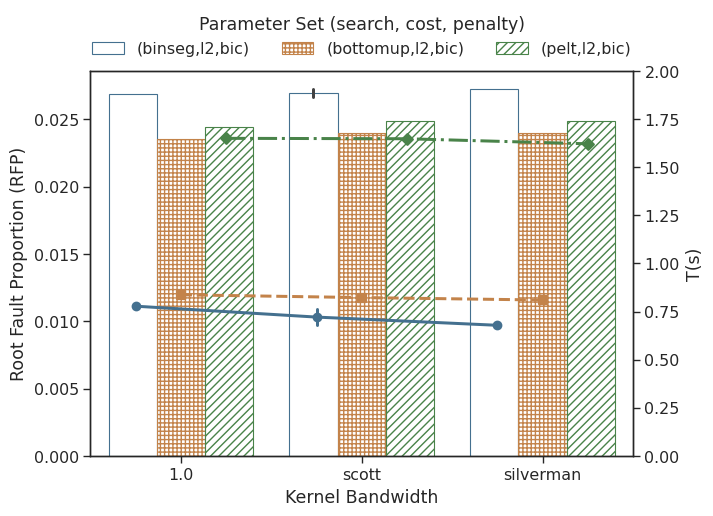

In [115]:
from itertools import cycle

plot_df = tsdr_results_df.reset_index()
plot_df["combination"] = "(" + plot_df["search_method"] + "," + plot_df["cost_model"] + "," + plot_df["penalty"].astype(str) + ")"

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)
sns.set_palette("tab10", 8, 0.5)
data_df = plot_df[plot_df["dataset"] == "SS-small"]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax2 = ax.twinx()

bar = sns.barplot(
    data=data_df, x="kde_bandwidth", y="RFP", hue="combination",
    alpha=1, color="none", fill=None, 
    ax=ax,
)
num_bar = 3
edge_colors = sum(map(lambda c: [c] * num_bar, sns.color_palette()), [])
# https://stackoverflow.com/questions/76233164/how-to-add-hatches-to-histplot-bars-and-legend
hatchs = ["","++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"][0:num_bar]
for container, hatch, handle, color in zip(ax.containers, hatchs, ax.get_legend().legend_handles, sns.color_palette()):
    handle.set_hatch(hatch)
    handle.set_edgecolor(color)
    for rectangle in container:
        rectangle.set_hatch(hatch)
        rectangle.set_edgecolor(color)

markers = ["o", "s", "D", "v", "^", "P", "X", "p", "d"]
sns.pointplot(
    data=data_df, x="kde_bandwidth", y="elapsed_time", hue="combination",
    # order=[], hue_order=[],
    dodge=0.5,
    markers=markers, linestyles=["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"],
    ax=ax2,
)


ax.set_xlabel("Kernel Bandwidth")
ax.set_ylabel("Root Fault Proportion (RFP)")
ax2.set_ylabel("T(s)")
ax2.set_ylim(0, 2.0)
ax2.get_legend().remove()
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title="Parameter Set (search, cost, penalty)", frameon=False,
)
fig.savefig(f"materials/plot_tsdr_params_sensitivity_SS-small_RFP.pdf", format="pdf", bbox_inches="tight")

plt.show()
fig.clf()
plt.close(fig=fig)

In [113]:
fig.clf()
plt.close(fig=fig)
plt.close("all")